## The Quantum Approximate Optimisation Algorithm (QAOA) using TKET.

Callum Macpherson

## The Max-Cut problem

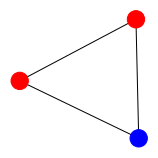

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edges_from([(0,1), (1,2), (2,0)])
plt.figure(figsize=(2,2))
nx.draw(G, node_color=['red', 'blue', 'red'])
plt.show()

For the previous 3 vertex graph the *problem Hamiltonian* is
\\[ H_P = \frac{1}{2} \big[ \left( Z \otimes Z \otimes I \right) + \left( Z \otimes I \otimes Z \right) + \left( I \otimes Z \otimes Z \right) \big] \\]


where you will notice that there is a \\( Z \otimes Z \\) acting between each vertex which is connected by an edge.

The *mixer Hamiltonian* has the form 
\\[ H_B =   \left( X \otimes I \otimes I \right) + \left( I \otimes X \otimes I \right) + \left( I \otimes I \otimes X \right)  \\]


where you will notice that there is an \\( X \\) acting on each vertex.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Circuit Construction for QAOA

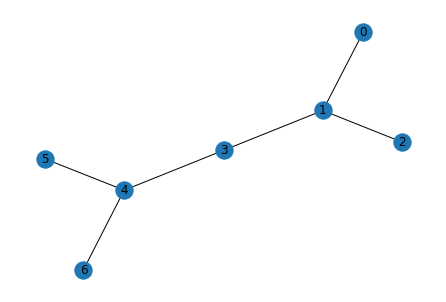

In [2]:
import networkx as nx

max_cut_graph_edges = [(0,1), (1,2), (1,3), (3,4), (4,5), (4,6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_results = [(0,1,0,0,1,0,0), (1,0,1,1,0,1,1)]

## Define Cost Hamiltonian: $\gamma H$

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{<jk>} (-Z_j \,Z_k +I )
\end{equation}
$$

from typing import List, Tuple, Any
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

def qaoa_graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], cost_angle: float) -> QubitPauliOperator:
    qpo_dict = {QubitPauliString(): len(edges)*0.5*cost_angle}
    for e in edges:
        term_string = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        qpo_dict[term_string] = -0.5*cost_angle
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, cost_angle)
print(cost_ham_qpo)

$$
\begin{equation}
H_P = 3 I^{\otimes 6} -0.5 \big[ Z_0 Z_1 + Z_1 Z_2 +Z_1 Z_3 +Z_3 Z_4 +Z_4 Z_5 +Z_4 Z_6  \big]
\end{equation}
$$

Using the same index convention as above

In [32]:
#Custom Cost function
from typing import List, Tuple, Any
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

def qaoa_graph_to_cost_hamiltonian(edges: List[Tuple[int, int]], cost_angle: float) -> QubitPauliOperator:
    qpo_dict = {QubitPauliString(): len(edges)*0.5*cost_angle}
    for e in edges:
        term_string1 = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        term_string2 = QubitPauliString([Qubit(e[0])], [Pauli.Z])
        term_string3 = QubitPauliString([Qubit(e[1])], [Pauli.Z])
        qpo_dict[term_string1] = -0.5*cost_angle
        qpo_dict[term_string2] = -0.5*single_node_cost_angle
        qpo_dict[term_string3] = -0.5*single_node_cost_angle
    return QubitPauliOperator(qpo_dict)

cost_angle = 1.0
single_node_cost_angle = 2.0
cost_ham_qpo = qaoa_graph_to_cost_hamiltonian(max_cut_graph_edges, cost_angle)
print(cost_ham_qpo)

{(): 3.00000000000000, (Zq[0], Zq[1]): -0.500000000000000, (Zq[0]): -1.00000000000000, (Zq[1]): -1.00000000000000, (Zq[1], Zq[2]): -0.500000000000000, (Zq[2]): -1.00000000000000, (Zq[1], Zq[3]): -0.500000000000000, (Zq[3]): -1.00000000000000, (Zq[3], Zq[4]): -0.500000000000000, (Zq[4]): -1.00000000000000, (Zq[4], Zq[5]): -0.500000000000000, (Zq[5]): -1.00000000000000, (Zq[4], Zq[6]): -0.500000000000000, (Zq[6]): -1.00000000000000}


## Hamiltonian Circuit

In [4]:
from pytket.utils import gen_term_sequence_circuit
from pytket import Circuit
from pytket.circuit import display

cost_ham_circuit = gen_term_sequence_circuit(cost_ham_qpo, Circuit(n_nodes))
display.render_circuit_jupyter(cost_ham_circuit)

In [5]:
from pytket.transform import Transform

Transform.DecomposeBoxes().apply(cost_ham_circuit)
display.render_circuit_jupyter(cost_ham_circuit)

## Construction of the Mixer Hamiltonian: $\beta B$

In [6]:
mixer_angle = 0.8
mixer_ham_qpo =  QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer_angle for i in range(n_nodes)})
mixer_ham_circuit = gen_term_sequence_circuit(mixer_ham_qpo, Circuit(n_nodes))
Transform.DecomposeBoxes().apply(mixer_ham_circuit)
display.render_circuit_jupyter(mixer_ham_circuit)

## Define the Initial State

In [7]:
def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c

superposition_circuit = qaoa_initial_circuit(n_nodes)

display.render_circuit_jupyter(superposition_circuit)

## Construct QAOA Circuit

Now lets define a function to create our entire QAOA circuit. For $p$ QAOA layers we expect that our circuit will require $2p$ parameters. Here we will pass and cost mixer parameters in as a list where the length of the list defines the number of layers.

In [8]:
# Custom Grover Mixer QAOA
from numpy import pi
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter

from typing import List, Tuple, Any
from pytket.utils import QubitPauliOperator
from pytket.pauli import QubitPauliString, Pauli
from pytket import Qubit

def GM_mixer_circuit(n_nodes, param):
    circ = Circuit(n_nodes)
    for qubit in range(n_nodes):
        circ.H(qubit)
        circ.X(qubit)
    #circ.add_gate(OpType.SXdg, [n_nodes-1])
    circ.add_gate(OpType.SX, [n_nodes-1])
    circ.add_gate(OpType.CnRy, param, list(range(0,n_nodes)))
    circ.add_gate(OpType.SXdg, [n_nodes-1])
    #circ.add_gate(OpType.SX, [n_nodes-1])
    #circ.add_gate(OpType.CnRy, -1*param, list(range(0,n_nodes)))
    for qubit in range(n_nodes):
        circ.X(qubit)
        circ.H(qubit)
    return circ

def qaoa_max_cut_circuit(edges: List[Tuple[int, int]],
                         n_nodes: int,
                         mixer_angles: List[float],
                         cost_angles: List[float]) -> Circuit:
    
    assert len(mixer_angles) == len(cost_angles)
    
    # initial state
    qaoa_circuit = qaoa_initial_circuit(n_nodes)
    #circ = Circuit(n_nodes)

 
    
    # add cost and mixer terms to state
    for cost, mixer in zip(cost_angles, mixer_angles):
        cost_ham = qaoa_graph_to_cost_hamiltonian(edges, cost)
        #mixer_ham = QubitPauliOperator({QubitPauliString([Qubit(i)], [Pauli.X]): mixer for i in range(n_nodes)})
        mixer_ham = GM_mixer_circuit(n_nodes, mixer)
        qaoa_circuit.append(gen_term_sequence_circuit(cost_ham, Circuit(n_nodes)))
        #qaoa_circuit.append(gen_term_sequence_circuit(mixer_ham, Circuit(n_nodes)))
        qaoa_circuit.append(mixer_ham)
        
    Transform.DecomposeBoxes().apply(qaoa_circuit)
    return qaoa_circuit

We also need to extract our energy expectation values from a `BackendResult` object after our circuit is processed by the device/simulator. We do this with the `get_max_cut_energy` function below. Note that the fact that the maxcut Hamiltonian contains only commuting terms means that we do not need to calculate our energy expectation using multiple measurement circuits. This may not the the case for a different problem Hamiltonian.

In [10]:
from typing import List, Tuple
from pytket.backends.backendresult import BackendResult

def get_max_cut_energy(edges: List[Tuple[int, int]], results: BackendResult) -> float:
    energy = 0.0
    dist = results.get_distribution()
    for i, j in edges:
        energy += sum((meas[i] ^ meas[j]) * prob for meas, prob in dist.items())

    return energy

In [11]:
from pytket.backends.backend import Backend
from typing import Callable
import numpy as np

def qaoa_instance(
    backend: Backend,
    compiler_pass: Callable[[Circuit], bool],
    guess_mixer_angles: np.array,
    guess_cost_angles: np.array,
    seed: int,
    shots: int = 5000,
) -> float:
    # step 1: get state guess
    my_prep_circuit = qaoa_max_cut_circuit(
        max_cut_graph_edges, n_nodes, guess_mixer_angles, guess_cost_angles
    )
    measured_circ = my_prep_circuit.copy().measure_all()
    compiler_pass(measured_circ)
    res = backend.run_circuit(measured_circ, shots, seed=seed)

    return get_max_cut_energy(max_cut_graph_edges, res)

## Optimise Energy by Guessing Parameters

In [12]:
def qaoa_optimise_energy(compiler_pass: Callable[[Circuit], bool],
                         backend: Backend,
                         iterations: int = 10,
                         n: int = 3,
                         shots: int = 5000,
                         seed: int= 12345):
    
    highest_energy = 0    
    best_guess_mixer_angles = [0 for i in range(n)]    
    best_guess_cost_angles = [0 for i in range(n)]
    rng = np.random.default_rng(seed)
    # guess some angles (iterations)-times and try if they are better than the best angles found before
    
    for i in range(iterations):
        print("iteration:"+str(i))
        
        guess_mixer_angles = rng.uniform(0, 1, n)#[1/6]*n#
        guess_cost_angles = rng.uniform(0, 1, n)
        
        qaoa_energy = qaoa_instance(backend,
                                    compiler_pass,
                                    guess_mixer_angles,
                                    guess_cost_angles,
                                    seed=seed,
                                    shots=shots)
        
        if(qaoa_energy > highest_energy):
            
            print("new highest energy found: ", qaoa_energy)
            
            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
            
    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    return best_guess_mixer_angles, best_guess_cost_angles

## Calculate the State for the final Parameters

In [ ]:
from pytket.backends.backend import Backend
import time

def qaoa_calculate(backend: Backend,
                   compiler_pass: Callable[[Circuit], bool],
                   shots: int = 5000,
                   iterations: int = 10,
                   seed: int = 12345,
                  ) -> BackendResult:
    
    # find the parameters for the highest energy
    best_mixer, best_cost = qaoa_optimise_energy(compiler_pass,
                                                 backend,
                                                 iterations,
                                                 13,
                                                 shots=shots,
                                                 seed=seed)
    
    # get the circuit with the final parameters of the optimisation:
    my_qaoa_circuit = qaoa_max_cut_circuit(max_cut_graph_edges,
                                           n_nodes,
                                           best_mixer,
                                           best_cost)

    my_qaoa_circuit.measure_all()

    print("depth: " + str(my_qaoa_circuit.depth()))
    compiler_pass(my_qaoa_circuit)
    handle = backend.process_circuit(my_qaoa_circuit, shots, seed=seed)

    result = backend.get_result(handle)    
    
    return result

from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

iters = 50

#%%time
startT = time.time()
res = qaoa_calculate(backend, backend.default_compilation_pass(2).apply, shots = 5000, iterations = iters, seed=12334)
diff = time.time() - startT
print("total time: " + str(diff) + " (s)")
print("Time per iteration: " + str(diff/iters) + " (s)")
#%%time
#print(res)

iteration:0
new highest energy found:  2.3028000000000004
iteration:1
new highest energy found:  3.2046
iteration:2
iteration:3
iteration:4
new highest energy found:  3.513000000000001
iteration:5
iteration:6
iteration:7
iteration:8
iteration:9
iteration:10
iteration:11
iteration:12
iteration:13
new highest energy found:  3.7758000000000003
iteration:14
iteration:15
iteration:16
iteration:17
iteration:18
iteration:19
iteration:20
iteration:21
iteration:22
iteration:23
iteration:24


## Results with the Noiseless Simulator

In [25]:
print(res)

BackendResult(q_bits={},c_bits={c[0]: 0, c[1]: 1, c[2]: 2, c[3]: 3, c[4]: 4, c[5]: 5, c[6]: 6},counts=None,shots=[[246]
 [248]
 [132]
 ...
 [234]
 [ 44]
 [244]],state=None,unitary=None,density_matrix=None)


In [15]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

#%%time
res = qaoa_calculate(backend, backend.default_compilation_pass(2).apply, shots = 5000, iterations = 100, seed=12345)

new highest energy found:  3.1432
new highest energy found:  3.283599999999999
new highest energy found:  4.361
new highest energy found:  4.925600000000001
new highest energy found:  4.941999999999999
highest energy:  4.941999999999999
best guess mixer angles:  [0.392 0.247 0.138]
best guess cost angles:  [0.592 0.738 0.608]
47


In [ ]:
from maxcut_plotting import plot_maxcut_results

plot_maxcut_results(res, 6, "GM-QAOA - K-vertex - 50 iterations")

Here the binary strings in the results correspond to the two optimal colourings of our graph.

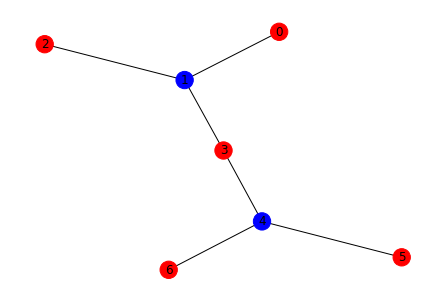

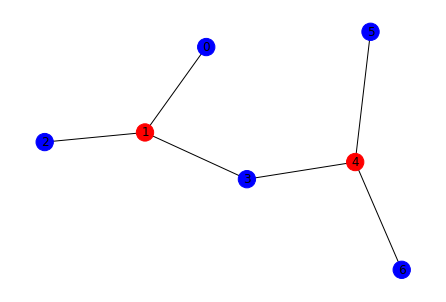

In [17]:
G = nx.Graph()
G.add_edges_from(max_cut_graph_edges)

H = nx.Graph()
H.add_edges_from(max_cut_graph_edges)

plt.figure(1)
nx.draw(G, labels={node: node for node in max_cut_graph.nodes()}, node_color= ['red', 'blue', 'red','red', 'blue', 'red', 'red'])
plt.figure(2)
nx.draw(H, labels={node: node for node in max_cut_graph.nodes()}, node_color= ['blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue'])

plt.show()

In [4]:
from pytket import Circuit, OpType

In [25]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter

n_qubit = 7
circ = Circuit(n_qubit)

for qubit in range(n_qubit):
    circ.H(qubit)
    circ.X(qubit)
#circ.H(3)
#S^3 = S^t
#circ.S(3
#circ.S(3)
circ.add_gate(OpType.SX, [n_qubit-1])
circ.add_gate(OpType.CnRy, 0, list(range(0,n_qubit)))
circ.add_gate(OpType.SXdg, [n_qubit-1])
#circ.S(3)
#circ.H(3)
for qubit in range(n_qubit):
    circ.X(qubit)
    circ.H(qubit)
render_circuit_jupyter(circ)

In [2]:
from pytket.circuit.display import render_circuit_jupyter

In [3]:
render_circuit_jupyter(circ)

NameError: name 'circ' is not defined

In [6]:
range(0, 5)


range(0, 5)

In [8]:
list(range(0,5))


[0, 1, 2, 3, 4]

In [33]:
list(1/3, 5)

TypeError: list expected at most 1 argument, got 2

In [27]:
import time
time.localtime().tm_sec


47

In [22]:
time.localtime()


time.struct_time(tm_year=2023, tm_mon=1, tm_mday=29, tm_hour=6, tm_min=52, tm_sec=31, tm_wday=6, tm_yday=29, tm_isdst=0)

In [23]:
time.time()


1674975158.919526